In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from datetime import datetime

import pytorch_lightning as pl
from torchgeo.datasets import BoundingBox
from rts_utils import get_time_bounds
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar
from torchgeo.models import ResNet50_Weights

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from rts_datamodule_retreat import LandsatPairInferenceDataModule
from rts_model_retreat import SiameseRTS
from rts_inference_retreat import predict_and_export

In [4]:
from rts_path import img_dir, dem_dir

Running on cryo-A100


In [5]:
UTM_CRS = "EPSG:32646"

polygon_dir = Path('/DATA/DATA1/joey/rts_polygons/')
rts_extent_gdf_path = polygon_dir / 'beiluhe_hoh_xil_mountain_extent_utm.gpkg'
rts_extent_gdf = gpd.read_file(rts_extent_gdf_path)
mint = datetime.strptime('19860101', "%Y%m%d").timestamp() # parse time_str then convert to POSIX timestamp
maxt = datetime.strptime('20231231', "%Y%m%d").timestamp()
minx, miny, maxx, maxy = rts_extent_gdf.total_bounds
test_roi = BoundingBox(minx, maxx, miny, maxy, mint, maxt)
test_roi

BoundingBox(minx=np.float64(437815.9904658653), maxx=np.float64(515098.9866292246), miny=np.float64(3837062.6820999067), maxy=np.float64(3929936.5625385013), mint=504892800.0, maxt=1703952000.0)

In [6]:
BAND_NUM = 4
USE_DEM = True

if BAND_NUM == 3:
    landsat_bands = ['SR_B4', 'SR_B3', 'SR_B2']  # in R G B order
elif BAND_NUM == 4:
    landsat_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']
elif BAND_NUM == 6:
    landsat_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

In [7]:
# logger = TensorBoardLogger(save_dir="lightning_logs",
#                            name="rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s/test")
# trainer = pl.Trainer(
#     accelerator='gpu',
#     devices=[0],
#     max_epochs=30,
#     log_every_n_steps=35,
#     logger=logger,
#     enable_progress_bar=True,
#     callbacks=[RichProgressBar(leave=False)]
# )

In [8]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(
    project="rts_retreat_project",
    name="unetpp_rgb_nir_dem_v59",
    save_dir="wandb_logs"
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=30,
    log_every_n_steps=35,
    logger=wandb_logger,
    enable_progress_bar=True,
    callbacks=[RichProgressBar(leave=False)]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
# ckpt_dir = Path(logger.save_dir) / logger.name / f'version_{logger.version-2}' / 'checkpoints'
# ckpt_path_best = list(ckpt_dir.glob('epoch*.ckpt'))[0]
# ckpt_path_best = Path(logger.save_dir) / logger.name / "best_model.ckpt"
# print(ckpt_path_best)

# ckpt_path_best = Path("lightning_logs") / logger_name / "version_52" / "checkpoints" / "epoch=45-step=4600.ckpt"
# logger_name = "rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test"

# ckpt_path_best = Path("lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_55/checkpoints/epoch=48-step=4949.ckpt")
ckpt_path_best = Path("wandb_logs/rts_retreat_project/75aelelm/checkpoints/epoch=78-step=7900.ckpt")
print("Best ckpt:", ckpt_path_best)

rts_model = SiameseRTS.load_from_checkpoint(checkpoint_path=ckpt_path_best,
                                          encoder_name="resnet50",
                                          encoder_weights=ResNet50_Weights.SENTINEL2_ALL_MOCO,
                                          in_bands=landsat_bands,
                                          use_dem=USE_DEM,
                                          out_classes=2
                                          )


Best ckpt: wandb_logs/rts_retreat_project/75aelelm/checkpoints/epoch=78-step=7900.ckpt
ResNet50_Weights.SENTINEL2_ALL_MOCO  loaded
input shape of target weight torch.Size([64, 5, 7, 7])
input shape of loaded weight torch.Size([64, 13, 7, 7])


In [10]:
# suffix = "dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s" # _count 
# export_dir = Path(f'/DATA/DATA1/ww/pr_mask_rts_aea_{suffix}')
# for test_year in range(2015, 2016):
#     print('test year: ', test_year)
#     if test_year > 2012:
#         dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LC08_MIX/')
#         test_img_dir = dataset_dir / f'{test_year}/test'
#     else:
#         dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LT05_MIX/')
#         test_img_dir = dataset_dir / f'{test_year}/test' # 
#     date_str = f'{test_year}0731'

#     # For 20100902
#     # test_img_dir = dataset_dir / f'{test_year}0930'
#     # date_str = f'{test_year}0902'
#     # For 20160930
#     # dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_SEP_TEST/')
#     # test_img_dir = dataset_dir / f'{test_year}0930/test/'
#     # date_str = f'{test_year}0930'

#     pathname = os.path.join(test_img_dir, '*.tif')

#     year_t = test_year
#     year_tm1 = test_year - 1

#     # handle no data years
#     if not list(glob.iglob(pathname, recursive=True)):
#         print('No tif files in ', test_img_dir)
#         continue

#     landsat_dm = LandsatPairInferenceDataModule(
#         img_dir=str(test_img_dir),
#         year_t=year_t,
#         year_tm1=year_tm1,
#         roi=test_roi,
#         dem_dir=str(dem_dir),
#         band_num=BAND_NUM,
#         use_dem=USE_DEM,
#         batch_size=1,
#         crs=UTM_CRS,
#         res=30,
#     )
#     start_date_str, end_date_str = get_time_bounds(landsat_dm.dataset.index)
#     print('From', start_date_str, 'to', end_date_str)
    
#     predict_and_export(
#         rts_model,
#         trainer,
#         landsat_dm,
#         model_name="unetpp_rgb_nir_dem_moco_blh_hxm",
#         date_str=date_str,
#         export_dir=export_dir,
#     )

In [11]:
from pathlib import Path

BAND_NUM = 4
USE_DEM = True

test_year_t = 2016
test_year_tm1 = 2015

if test_year_t > 2012:
    dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LC08_MIX/')
else:
    dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LT05_MIX/')

year_dir = dataset_dir / f"{test_year_t}"
test_img_dir = year_dir / "test"   # 只用于检查是否有文件
print("推理影像目录:", test_img_dir)

landsat_dm_inf = LandsatPairInferenceDataModule(
    img_dir=str(test_img_dir),          # 注意：传 year 调用 TestLandsat*，不是 year/test
    year_t=test_year_t,
    year_tm1=test_year_tm1,
    roi=test_roi,                  # 你的目标 ROI (BoundingBox)
    dem_dir=str(dem_dir),
    band_num=BAND_NUM,             # 例如 4
    use_dem=USE_DEM,               # True
    batch_size=1,
    crs=UTM_CRS,
    res=30,
    use_l7=False, # for DEBUG
    num_workers=0,
)

推理影像目录: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2016/test
🔧 创建多年份数据集，年份: [2016, 2015]
检测到年份目录结构，基础目录: /DATA/DATA1/joey/LANDSAT_LC08_MIX
  添加年份 2016: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2016/test
    L8/9 数据集创建成功，边界: BoundingBox(minx=437815.9904658653, maxx=515115.0, miny=3836925.0, maxy=3930075.0, mint=1451577600.0, maxt=1483199999.999999)
  添加年份 2015: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2015/test
    L8/9 数据集创建成功，边界: BoundingBox(minx=438075.0, maxx=515115.0, miny=3836925.0, maxy=3930075.0, mint=1420041600.0, maxt=1451577599.999999)
最终数据集 (仅L8/9)，边界: BoundingBox(minx=437815.9904658653, maxx=515115.0, miny=3836925.0, maxy=3930075.0, mint=1420041600.0, maxt=1483199999.999999)


In [12]:
# # DEBUG

# from pathlib import Path
# import rasterio
# import numpy as np
# import torch

# def check_data_consistency():
#     """检查两年数据是否一致"""
    
#     # 你的配置
#     BAND_NUM = 4
#     USE_DEM = True
#     test_year_t = 2016
#     test_year_tm1 = 2015
    
#     print("="*50)
#     print("🔍 数据一致性检查")
#     print("="*50)
    
#     # 1. 检查目录结构
#     print(f"1. 检查目录结构:")
    
#     if test_year_t > 2012:
#         dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LC08_MIX/')
#     else:
#         dataset_dir = Path('/DATA/DATA1/joey/LANDSAT_LT05_MIX/')
    
#     year_t_dir = dataset_dir / f"{test_year_t}"
#     year_tm1_dir = dataset_dir / f"{test_year_tm1}"
    
#     print(f"   {test_year_t} 目录: {year_t_dir}")
#     print(f"   存在: {year_t_dir.exists()}")
    
#     print(f"   {test_year_tm1} 目录: {year_tm1_dir}")
#     print(f"   存在: {year_tm1_dir.exists()}")
    
#     # 检查test子目录
#     test_img_dir_t = year_t_dir / "test"
#     test_img_dir_tm1 = year_tm1_dir / "test"
    
#     print(f"   {test_year_t}/test: {test_img_dir_t.exists()}")
#     print(f"   {test_year_tm1}/test: {test_img_dir_tm1.exists()}")
    
#     # 2. 列出文件
#     print(f"\n2. 检查文件列表:")
    
#     if test_img_dir_t.exists():
#         files_t = list(test_img_dir_t.glob("*.tif"))
#         print(f"   {test_year_t} 文件数量: {len(files_t)}")
#         if files_t:
#             print(f"   示例文件: {files_t[0].name}")
    
#     if test_img_dir_tm1.exists():
#         files_tm1 = list(test_img_dir_tm1.glob("*.tif"))
#         print(f"   {test_year_tm1} 文件数量: {len(files_tm1)}")
#         if files_tm1:
#             print(f"   示例文件: {files_tm1[0].name}")
    
#     # 3. 检查DataModule实际加载的数据
#     print(f"\n3. 检查DataModule加载:")
    
#     try:
#         # 创建你的DataModule
#         landsat_dm_inf = LandsatPairInferenceDataModule(
#             img_dir=str(test_img_dir_t),
#             year_t=test_year_t,
#             year_tm1=test_year_tm1,
#             roi=test_roi,
#             dem_dir=str(dem_dir),
#             band_num=BAND_NUM,
#             use_dem=USE_DEM,
#             batch_size=1,
#             crs=UTM_CRS,
#             res=30,
#             use_l7=False,
#             num_workers=0,
#         )
        
#         # 设置推理阶段
#         landsat_dm_inf.setup('predict')
        
#         # 获取数据加载器
#         dataloader = landsat_dm_inf.predict_dataloader()
        
#         print(f"   DataLoader长度: {len(dataloader)}")
        
#         # 检查第一个batch
#         first_batch = next(iter(dataloader))
        
#         print(f"   Batch keys: {list(first_batch.keys())}")
        
#         if 'image_t' in first_batch and 'image_tm1' in first_batch:
#             image_t = first_batch['image_t']
#             image_tm1 = first_batch['image_tm1']
            
#             print(f"   image_t shape: {image_t.shape}")
#             print(f"   image_tm1 shape: {image_tm1.shape}")
            
#             print(f"   image_t range: [{image_t.min():.4f}, {image_t.max():.4f}]")
#             print(f"   image_tm1 range: [{image_tm1.min():.4f}, {image_tm1.max():.4f}]")
            
#             # 关键检查：两个图像的差异
#             diff = torch.abs(image_t - image_tm1)
#             mean_diff = diff.mean().item()
#             max_diff = diff.max().item()
            
#             print(f"   平均差异: {mean_diff:.6f}")
#             print(f"   最大差异: {max_diff:.6f}")
            
#             # 判断是否相同
#             if mean_diff < 1e-6:
#                 print("   ❌ 警告: 两年数据几乎相同!")
#             elif mean_diff < 0.01:
#                 print("   ⚠️  注意: 两年数据差异很小")
#             else:
#                 print("   ✅ 两年数据有明显差异")
            
#             # 检查统计特征
#             print(f"\n4. 统计特征对比:")
#             print(f"   {test_year_t} - 均值: {image_t.mean(dim=[2,3])}")
#             print(f"   {test_year_tm1} - 均值: {image_tm1.mean(dim=[2,3])}")
            
#             print(f"   {test_year_t} - 标准差: {image_t.std(dim=[2,3])}")
#             print(f"   {test_year_tm1} - 标准差: {image_tm1.std(dim=[2,3])}")
        
#         # 检查多个batch
#         print(f"\n5. 检查多个batch的一致性:")
#         batch_diffs = []
        
#         for i, batch in enumerate(dataloader):
#             if i >= 5:  # 只检查前5个batch
#                 break
                
#             img_t = batch['image_t']
#             img_tm1 = batch['image_tm1']
            
#             diff = torch.abs(img_t - img_tm1).mean().item()
#             batch_diffs.append(diff)
            
#             print(f"   Batch {i}: 差异 = {diff:.6f}")
        
#         if batch_diffs:
#             avg_diff = np.mean(batch_diffs)
#             print(f"   平均批次差异: {avg_diff:.6f}")
            
#             if avg_diff < 1e-6:
#                 print("   ❌ 严重问题: 所有batch的两年数据都相同!")
#             elif avg_diff < 0.01:
#                 print("   ⚠️  可能问题: 两年数据差异普遍很小")
#             else:
#                 print("   ✅ 数据看起来正常")
                
#     except Exception as e:
#         print(f"   ❌ DataModule创建失败: {e}")
#         return False
    
#     return True

# # 运行检查
# check_data_consistency()

In [13]:
# 让 datamodule 构建内部 dataset/sampler
landsat_dm_inf.prepare_data()
landsat_dm_inf.setup("predict")

In [14]:
rts_model.eval()
predictions = trainer.predict(
    model=rts_model,
    dataloaders=landsat_dm_inf.predict_dataloader()
)

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.

wandb: Currently logged in as: wei-wu24 (wei-wu24-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


In [15]:
# predict_loader = landsat_dm_inf.predict_dataloader()
# predictions_list = trainer.predict(rts_model, predict_loader)

# print("num batches:", len(predictions_list))

In [16]:
batch_pred = predictions[0]  # 第一个 batch 的预测结果

image_t = batch_pred["image_t"]      # [B,C,H,W]
image_tm1 = batch_pred["image_tm1"]    # [B,C,H,W]
pred_heat = batch_pred["heatmap"]    # [B,1,H,W]
pred_ret = batch_pred["retreat"] # [B,1,H,W]，已乘 retreat_scale
prob_mask = batch_pred["prob_mask"]    # [B,1,H,W]

In [17]:
# ## DEBUG

# import torch
# import numpy as np

# # 检查 predictions 中 t 和 t-1 数据是否相同
# batch_pred = predictions[0]

# image_t = batch_pred["image_t"]      # [B,C,H,W]
# image_tm1 = batch_pred["image_tm1"]  # [B,C,H,W]

# print("="*60)
# print("🔍 诊断: 检查 t 和 t-1 年数据是否相同")
# print("="*60)

# # 计算差异
# diff = torch.abs(image_t - image_tm1)
# print(f"image_t shape: {image_t.shape}")
# print(f"image_tm1 shape: {image_tm1.shape}")
# print(f"image_t range: [{image_t.min():.4f}, {image_t.max():.4f}]")
# print(f"image_tm1 range: [{image_tm1.min():.4f}, {image_tm1.max():.4f}]")
# print(f"差异 - mean: {diff.mean():.6f}, max: {diff.max():.6f}")

# if diff.mean() < 1e-6:
#     print("❌ 警告: image_t 和 image_tm1 完全相同!")
#     print("   问题可能在 DataModule 或 Dataset 的数据加载逻辑中")
# else:
#     print("✅ 两年数据有差异")

# # 检查是否有 year 信息
# if "year_t" in batch_pred:
#     print(f"year_t: {batch_pred['year_t']}")
# if "year_tm1" in batch_pred:
#     print(f"year_tm1: {batch_pred['year_tm1']}")

# # 检查路径信息（如果有）
# if "path_t" in batch_pred:
#     print(f"path_t: {batch_pred['path_t']}")
# if "path_tm1" in batch_pred:
#     print(f"path_tm1: {batch_pred['path_tm1']}")

Sample 0:
Heat range: -0.09263565391302109 1.113918423652649
Retreat range: -1.2689086198806763 1.4239016771316528
Prob range: 7.43009704228205e-30 1.0


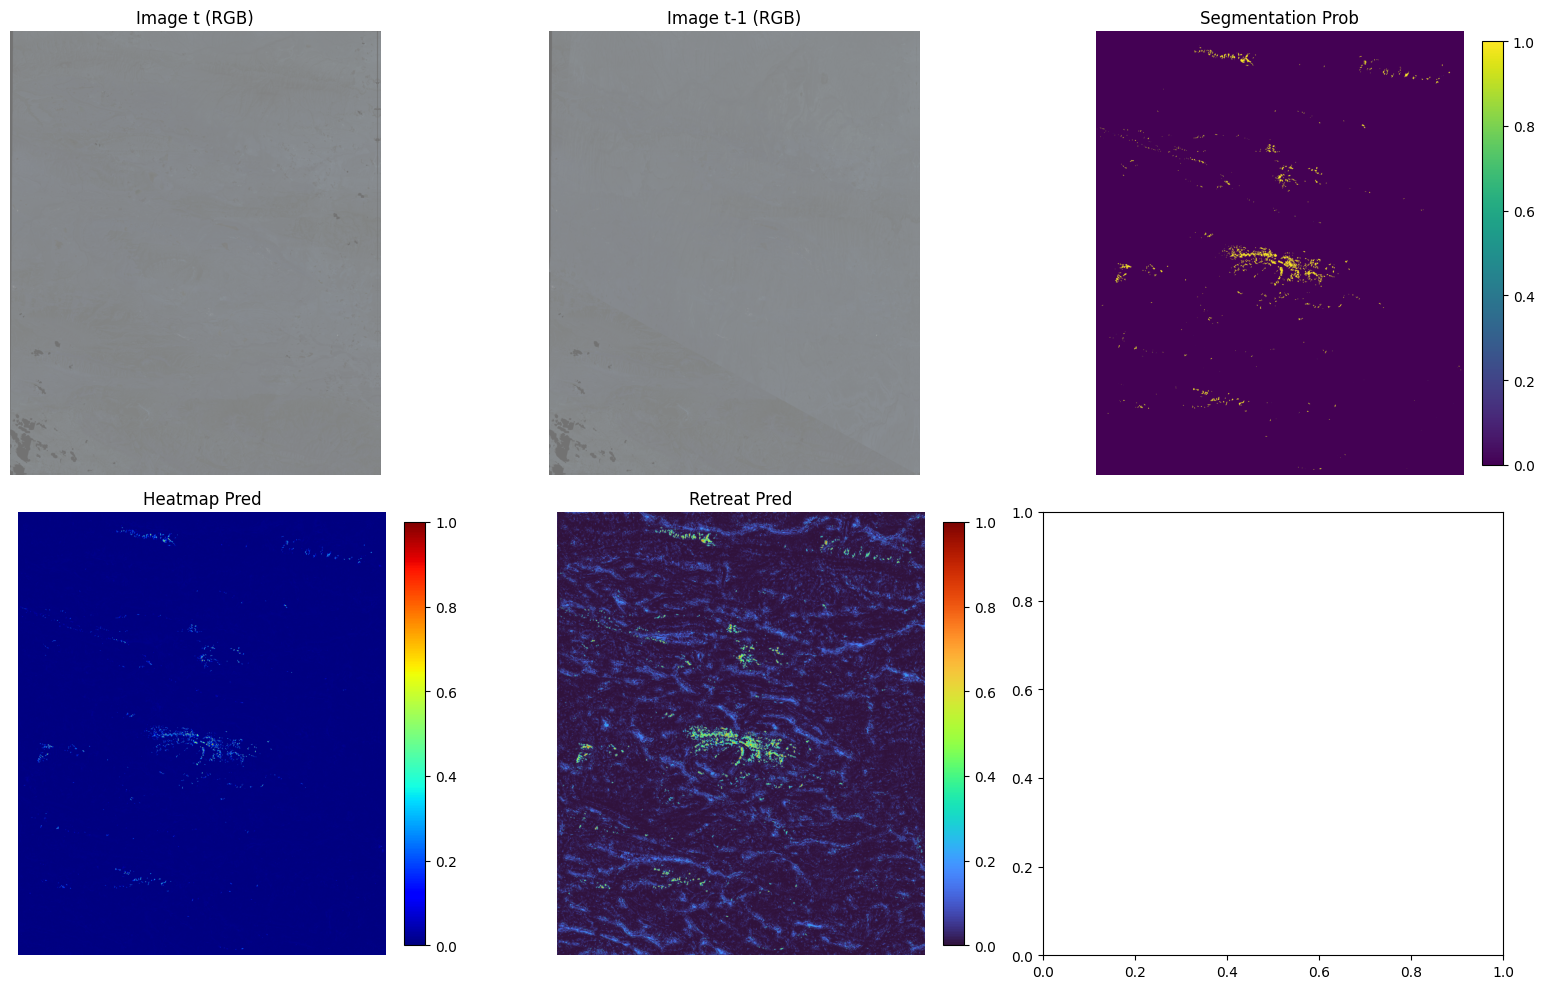

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def percentile_stretch(img, low=2, high=98):
    if img.ndim == 3:
        result = np.zeros_like(img, dtype=np.float32)
        for c in range(img.shape[2]):
            channel = img[:, :, c]
            p_low = np.percentile(channel, low)
            p_high = np.percentile(channel, high)
            if p_high - p_low > 1e-6:
                result[:, :, c] = np.clip((channel - p_low) / (p_high - p_low), 0, 1)
            else:
                result[:, :, c] = 0.5
        return result
    else:
        p_low = np.percentile(img, low)
        p_high = np.percentile(img, high)
        if p_high - p_low > 1e-6:
            return np.clip((img - p_low) / (p_high - p_low), 0, 1)
        else:
            return np.full_like(img, 0.5, dtype=np.float32)

def vis_batch(image_t, image_tm1, prob_mask, pred_heat, pred_ret, max_samples=4):
    B = image_t.shape[0]
    N = min(B, max_samples)

    for i in range(N):
        img_t = image_t[i]      # [C,H,W]
        img_tm1 = image_tm1[i]
        pm = prob_mask[i, 0].numpy()      # [H,W]
        h_pr = pred_heat[i, 0].numpy()      # [H,W]
        r_pr = pred_ret[i, 0].numpy()       # [H,W]

        # RGB_t
        if img_t.shape[0] >= 3:
            rgb_t = img_t[:3].numpy().transpose(1, 2, 0)  # [H,W,3]
            # 如果训练时做了标准化，可以简单做一个反向/clip，这里只作裁剪方便看
            rgb_t = np.clip((rgb_t + 2) / 4, 0, 1)
            # rgb_t = percentile_stretch(rgb_t)
        else:
            rgb_t = img_t[0].numpy()

        # RGB_tm1
        if img_tm1.shape[0] >= 3:
            rgb_tm1 = img_tm1[:3].numpy().transpose(1, 2, 0)
            rgb_tm1 = np.clip((rgb_tm1 + 2) / 4, 0, 1)
            # rgb_tm1 = percentile_stretch(rgb_tm1)
        else:
            rgb_tm1 = img_tm1[0].numpy()

        print(f"Sample {i}:")
        print("Heat range:", float(h_pr.min()), float(h_pr.max()))
        print("Retreat range:", float(r_pr.min()), float(r_pr.max()))
        print("Prob range:", float(pm.min()), float(pm.max()))

        fig, axes = plt.subplots(2, 3, figsize=(16, 10))

        axes[0, 0].imshow(rgb_t)
        axes[0, 0].set_title("Image t (RGB)")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(rgb_tm1)
        axes[0, 1].set_title("Image t-1 (RGB)")
        axes[0, 1].axis("off")

        im = axes[0, 2].imshow(pm, vmin=0, vmax=1, cmap="viridis")
        axes[0, 2].set_title("Segmentation Prob")
        axes[0, 2].axis("off")
        fig.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)

        im = axes[1, 0].imshow(h_pr, vmin=0, vmax=1, cmap="jet")
        axes[1, 0].set_title("Heatmap Pred")
        axes[1, 0].axis("off")
        fig.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)

        im = axes[1, 1].imshow(r_pr, vmin=0, vmax=1, cmap="turbo")
        axes[1, 1].set_title("Retreat Pred")
        axes[1, 1].axis("off")
        fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

        # Overlay: 在 t 年 RGB 上叠加 heat 高值和 retreat 高值轮廓
        # axes[1, 2].imshow(rgb_t)
        # try:
        #     heat_thr = h_pr.min() + 0.7 * (h_pr.max() - h_pr.min())
        #     ret_thr = r_pr.min() + 0.7 * (r_pr.max() - r_pr.min())
        #     axes[1, 2].contour(h_pr >= heat_thr, colors="yellow", linewidths=1)
        #     axes[1, 2].contour(r_pr >= ret_thr, colors="red", linewidths=1)
        #     axes[1, 2].set_title("RGB + Heat(y) + Retreat(r)")
        # except Exception:
        #     axes[1, 2].set_title("RGB overlay")
        # axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

# 调用
vis_batch(image_t, image_tm1, prob_mask, pred_heat, pred_ret, max_samples=4)

In [19]:
suffix = "dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s"
export_dir = Path(f"/DATA/DATA1/ww/pr_mask_rts_aea_{suffix}")

predict_and_export(
    rts_model,
    trainer,
    landsat_dm_inf,
    model_name="unetpp_rgb_nir_dem_moco_blh_hxm",
    date_str=f"{test_year_t}0731",
    export_dir=export_dir,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


pr_heatmap_mean shape: (3096, 2577)
image_count 范围: [0.0, 6.0]
save_predictions shapes (H,W):
  pr_heatmap : (3096, 2577)
  pr_segment : (3096, 2577)
  pr_count   : (3096, 2577)
  image_count: (3096, 2577)
Prediction results saved:
 /DATA/DATA1/ww/pr_mask_rts_aea_dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s/pr_mask_20160731_mean_unetpp_rgb_nir_dem_moco_blh_hxm.tif
Successfully exported to: /DATA/DATA1/ww/pr_mask_rts_aea_dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s/pr_mask_20160731_mean_unetpp_rgb_nir_dem_moco_blh_hxm.tif


True

In [20]:
from pathlib import Path
import rasterio
import numpy as np

predict_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_mean_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

with rasterio.open(predict_path) as src:
    pr_heatmap_mean = src.read(1)

print("pr_heatmap_mean stats:",
      "min", float(pr_heatmap_mean.min()),
      "max", float(pr_heatmap_mean.max()),
      "mean", float(pr_heatmap_mean.mean()),
      "nonzero", int((pr_heatmap_mean > 0).sum()))

pr_heatmap_mean stats: min -0.04365352541208267 max 0.8881074786186218 mean 0.004280926659703255 nonzero 7069917


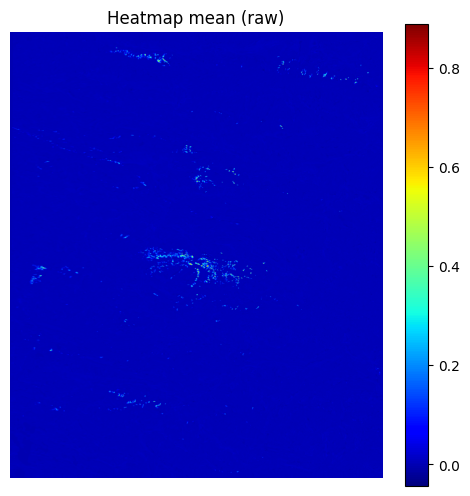

num points > 0.5 : 817


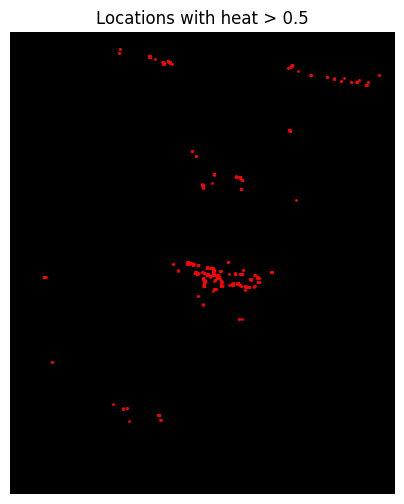

In [21]:
h_np = pr_heatmap_mean
plt.figure(figsize=(6,6))
plt.imshow(h_np, cmap="jet")
plt.colorbar()
plt.title("Heatmap mean (raw)")
plt.axis("off")
plt.show()

ys, xs = np.where(h_np > 0.5)   # 例如 heat>0.01 的点
print("num points >", 0.5, ":", len(xs))

plt.figure(figsize=(6,6))
plt.imshow(np.zeros_like(h_np), cmap="gray")
plt.scatter(xs, ys, s=1, c="red")
plt.title("Locations with heat > 0.5")
plt.axis("off")
plt.show()

掩膜阈值: segment > 0.5
掩膜内像素数: 45258
原始 heatmap 非零像素: 7069917
掩膜后 heatmap 非零像素: 45110
掩膜后 heatmap 范围: [-0.0253, 0.8881]


/tmp/ipykernel_3367423/3939221879.py:54: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3367423/3939221879.py:54: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3367423/3939221879.py:54: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3367423/3939221879.py:54: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


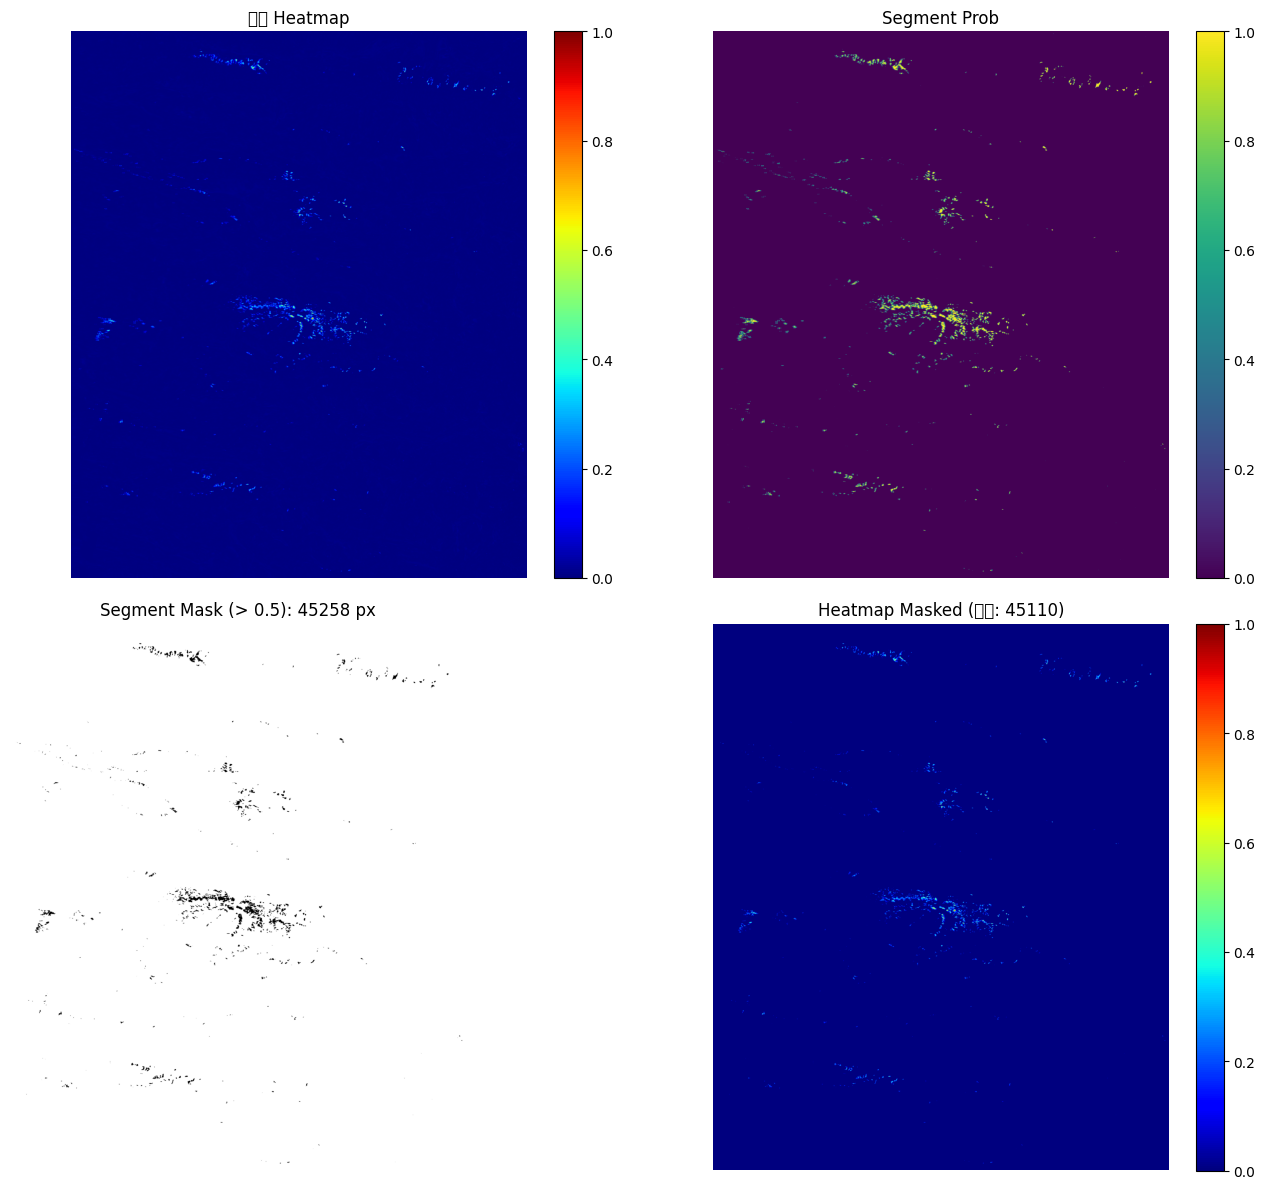

✅ 掩膜后结果已导出: /DATA/DATA1/ww/pr_mask_rts_aea_dem_aug/rgb_nir_dem_16_22_r4_4_awing_l7_year_roi_80s/pr_mask_20160731_segmasked_0.5_unetpp_rgb_nir_dem_moco_blh_hxm.tif


In [23]:
# 用 segment > 0.5 作为掩膜筛选 heatmap 并导出

from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 读取原始预测结果
predict_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_mean_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

with rasterio.open(predict_path) as src:
    pr_heatmap = src.read(1)
    pr_segment = src.read(2)
    pr_count = src.read(3)
    image_count = src.read(4)
    profile = src.profile
    transform = src.transform
    crs = src.crs

# ✅ 用 segment > threshold 作为掩膜筛选 heatmap
threshold = 0.5
seg_mask = pr_segment > threshold
heatmap_masked = np.where(seg_mask, pr_heatmap, 0)

# 统计信息
print(f"掩膜阈值: segment > {threshold}")
print(f"掩膜内像素数: {seg_mask.sum()}")
print(f"原始 heatmap 非零像素: {(pr_heatmap > 0).sum()}")
print(f"掩膜后 heatmap 非零像素: {(heatmap_masked > 0).sum()}")
print(f"掩膜后 heatmap 范围: [{heatmap_masked.min():.4f}, {heatmap_masked.max():.4f}]")

# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

im = axes[0, 0].imshow(pr_heatmap, cmap="jet", vmin=0, vmax=1)
axes[0, 0].set_title(f"原始 Heatmap")
axes[0, 0].axis("off")
fig.colorbar(im, ax=axes[0, 0], fraction=0.046, pad=0.04)

im = axes[0, 1].imshow(pr_segment, cmap="viridis", vmin=0, vmax=1)
axes[0, 1].set_title(f"Segment Prob")
axes[0, 1].axis("off")
fig.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)

axes[1, 0].imshow(seg_mask, cmap="Greys")
axes[1, 0].set_title(f"Segment Mask (> {threshold}): {seg_mask.sum()} px")
axes[1, 0].axis("off")

im = axes[1, 1].imshow(heatmap_masked, cmap="jet", vmin=0, vmax=1)
axes[1, 1].set_title(f"Heatmap Masked (非零: {(heatmap_masked > 0).sum()})")
axes[1, 1].axis("off")
fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# ✅ 导出掩膜后的结果
masked_path = Path(export_dir) / f"pr_mask_{test_year_t}0731_segmasked_{threshold}_unetpp_rgb_nir_dem_moco_blh_hxm.tif"

profile.update(count=4, dtype='float32')

with rasterio.open(masked_path, 'w', **profile) as dst:
    dst.write(heatmap_masked.astype(np.float32), 1)
    dst.write(seg_mask.astype(np.float32), 2)
    dst.write(pr_count.astype(np.float32), 3)
    dst.write(image_count.astype(np.float32), 4)
    
    dst.set_band_description(1, "heatmap_masked")
    dst.set_band_description(2, "segment_mask")
    dst.set_band_description(3, "pr_count")
    dst.set_band_description(4, "image_count")

print(f"✅ 掩膜后结果已导出: {masked_path}")